# Code for Hierarchical Clustering to obtain labels (suitability category)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch

In [2]:
# Set seed for whole notebook
import random
random.seed(10)

In [3]:
#Loading locational dataset
df = pd.read_csv('final-scaled-df.csv', index_col='FIPS')
df.head(20)

,Income,DSCI,PQ1,PQ2,PQ3,PQ4,TQ1,TQ2,TQ3,TQ4,Forest,Agriculture,Biomass,Energy,Water Availability,Watershed
FIPS,,,,,,,,,,,,,,,,
51001,0.075854,0.148920,0.319901,0.435870,0.410805,0.412876,0.398849,0.223717,0.178736,0.296552,0.064338,0.289624,0.185901,0.601097,0.020793,1
51003,0.108095,0.182011,0.281478,0.361577,0.330150,0.398268,0.652957,0.669414,0.672845,0.580575,0.679813,0.081093,0.354645,0.494455,0.157825,1
51005,0.187226,0.147870,0.208440,0.382735,0.309672,0.361536,0.590581,0.651482,0.660489,0.531379,0.897165,0.020858,0.654945,0.494455,0.083128,1
51007,0.157467,0.144258,0.319836,0.347694,0.488828,0.370654,0.753323,0.808243,0.809483,0.716207,0.651586,0.155517,0.648261,0.515919,0.018988,1
51009,0.184217,0.145333,0.205452,0.416978,0.325681,0.367647,0.499006,0.525380,0.539368,0.463678,0.770831,0.072140,0.236541,0.502679,0.145085,1
51011,0.140248,0.158561,0.278259,0.427413,0.398133,0.403431,0.427002,0.337238,0.280747,0.347356,0.662506,0.159655,0.099752,0.516467,0.082587,1
51013,0.142115,0.105105,0.229655,0.409510,0.284420,0.314118,0.436525,0.430658,0.397845,0.371264,0.089268,0.001349,0.101754,0.494455,0.023823,1
51015,0.197927,0.147820,0.225123,0.379990,0.321457,0.383072,0.615071,0.686479,0.682759,0.561379,0.582228,0.137797,0.421279,0.494455,0.126500,1
51017,0.382682,0.130588,0.262562,0.372108,0.370891,0.394608,0.681005,0.768185,0.779741,0.641724,0.899831,0.020852,0.165266,0.000000,0.098558,1


In [4]:
TEST_RATIO = 0.2
BATCH_SIZE = 64

size_all = len(df)

# training/val/test dataset
size_train = size_all - 6
size_val = int(size_train * TEST_RATIO)
size_train_sub = size_train - size_val

# split data into train and test
# Test = 6 counties of interst: Accomack, Fauquier, Greensville, Hanover, Rockingham, Wise
dataset_test = df.loc[[51001, 51061, 51081, 51085, 51165, 51195]]

# Train = all except 6 counties of interest
dataset_train = df.drop([51001, 51061, 51081, 51085, 51165, 51195])


# Reforestation Clustering

In [5]:
cols = ['Income', 'DSCI', 'PQ1', 'PQ2', 'PQ3', 'PQ4', 'TQ1', 'TQ2', 'TQ3', 'TQ4', 'Forest', 'Agriculture', 'Biomass', 'Energy', 'Water Availability', 'Watershed']


# Using the elbow method to determine the k value to be applied
k_rng = range(1, 10)
sse = []
for k in k_rng:
    km = KMeans(n_clusters=k, n_init=10)
    km.fit(df[['PQ1', 'PQ2', 'PQ3', 'PQ4', 'TQ1', 'TQ2', 'TQ3', 'TQ4', 'Forest','Water Availability']])
    sse.append(km.inertia_)

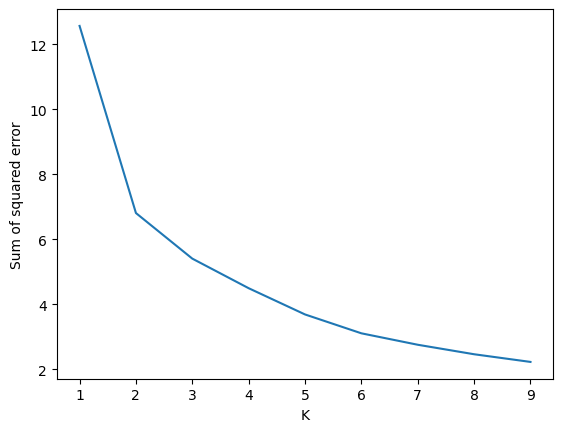

In [6]:
# Plot to obtain elbow
plt.xlabel('K')
plt.ylabel('Sum of squared error')
plt.plot(k_rng, sse)

In [7]:
# create clusters using k value = 4
hc = AgglomerativeClustering(n_clusters=4, affinity = 'euclidean', linkage = 'ward')

In [8]:
# Determining mean cluster characterisitics REFORESTATION
y_hc = hc.fit_predict(dataset_train[['PQ1', 'PQ2', 'PQ3', 'PQ4', 'TQ1', 'TQ2', 'TQ3', 'TQ4', 'Forest','Water Availability']])
dataset_train['Reforest'] = y_hc
dataset_train.sort_values("Reforest", inplace = True, ascending=True)

#average input vars by cluster
df_rfcluster = dataset_train.groupby('Reforest').mean()


# Determining mean cluster characterisitics ENHANCED WEATHERING
y_hc = hc.fit_predict(dataset_train[['PQ1', 'PQ2', 'PQ3', 'PQ4', 'TQ1', 'TQ2', 'TQ3', 'TQ4', 'Income', 'Energy', 'Agriculture']])
dataset_train['EW'] = y_hc
dataset_train.sort_values("EW", inplace = True, ascending=True)

#average input vars by cluster
df_ewcluster = dataset_train.groupby('EW').mean()


# Determining mean cluster characterisitics BIOCHAR
y_hc = hc.fit_predict(dataset_train[['PQ1', 'PQ2', 'PQ3', 'PQ4', 'TQ1', 'TQ2', 'TQ3', 'TQ4', 'Income', 'Biomass','Agriculture']])
dataset_train['Biochar'] = y_hc
dataset_train.sort_values("Biochar", inplace = True, ascending=True)

#average input vars by cluster
df_biocluster = dataset_train.groupby('Biochar').mean()

/Users/rachelholman/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/rachelholman/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/rachelholman/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


<Axes: ylabel='Biochar'>

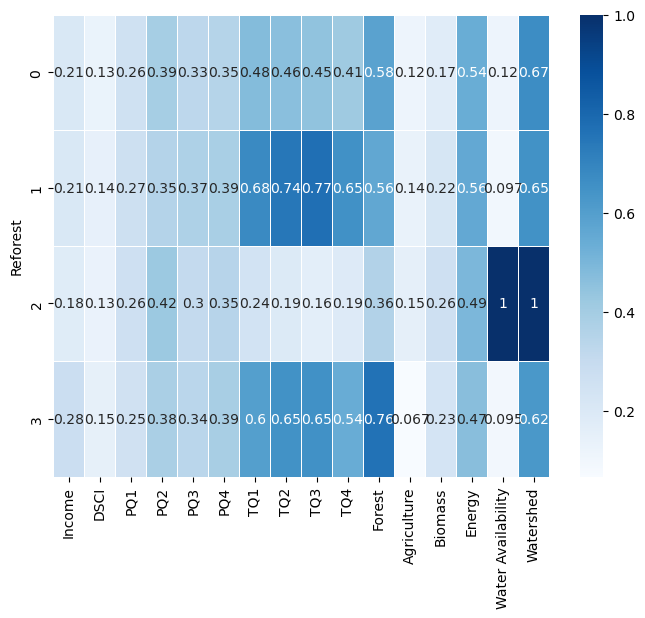

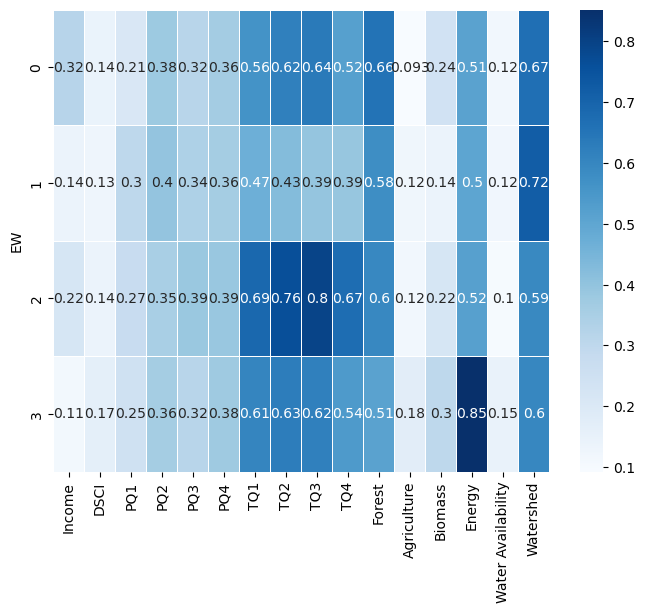

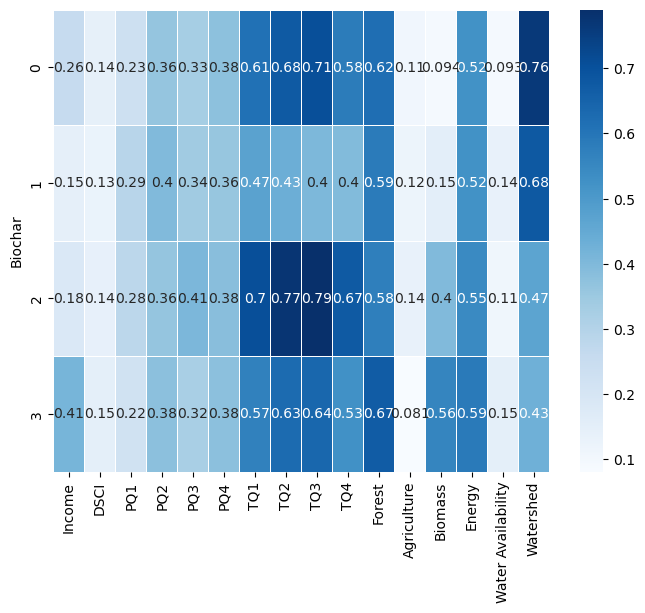

In [9]:
#Heatmap of cluster characteristics reforestation
plt.figure(figsize=(8,6))
sns.heatmap(df_rfcluster[cols], annot=True, cmap="Blues", linewidths=.5)

plt.figure(figsize=(8,6))
sns.heatmap(df_ewcluster[cols], annot=True, cmap="Blues", linewidths=.5)

plt.figure(figsize=(8,6))
sns.heatmap(df_biocluster[cols], annot=True, cmap="Blues", linewidths=.5)

In [10]:
# see how clusters are distributed
dataset_train['Reforest'].value_counts()

1    34
0    33
3    16
2     1
Name: Reforest, dtype: int64

In [11]:
dataset_train['EW'].value_counts()

0    27
2    27
1    25
3     5
Name: EW, dtype: int64

In [12]:
dataset_train['Biochar'].value_counts()

0    34
1    28
2    15
3     7
Name: Biochar, dtype: int64

In [19]:
# Look at counties in smallest cluster
dataset_train[dataset_train['EW'] == 3]

,Income,DSCI,PQ1,PQ2,PQ3,PQ4,TQ1,TQ2,TQ3,TQ4,Forest,Agriculture,Biomass,Energy,Water Availability,Watershed,Reforest,EW,Biochar
FIPS,,,,,,,,,,,,,,,,,,,
51181,0.137399,0.169813,0.248834,0.345843,0.294368,0.409739,0.613815,0.651193,0.637069,0.540230,0.493673,0.198127,0.227214,0.815780,0.056177,1,1,3,0
51177,0.070653,0.176921,0.258522,0.334450,0.325130,0.395654,0.654631,0.687202,0.683190,0.582759,0.611570,0.099218,0.212923,0.892711,0.029957,1,1,3,0
51101,0.117433,0.176286,0.280493,0.378203,0.338935,0.405359,0.646886,0.676500,0.661207,0.569195,0.499783,0.201049,0.177208,0.724926,0.015200,1,1,3,0
51117,0.149583,0.123421,0.168966,0.407117,0.285522,0.295588,0.428467,0.415040,0.400144,0.381149,0.590437,0.114752,0.270912,1.000000,0.498570,0,0,3,1
51175,0.080736,0.181835,0.278785,0.336206,0.340037,0.377647,0.683621,0.707014,0.713218,0.619655,0.363975,0.264080,0.616150,0.828688,0.137757,0,1,3,2


# Categorizing the clusters as suitability levels

In [13]:
# Maybe redo if we can get more data and redo clusters

# 0 = highly suitable (most forest land, mild summer temps, warm winter temps, faitly high precip, high income, avg drought)
# 2 = suitable (high income, high summer and wimter temps, high rain, good about of forest)
# 1 = possible (lots of forest land, slightly cold, lots of rain, not the best income)
# 3 = unsuitable (too cold, too little forest land, low income)

# Supervised ML for suitability prediction

# Random Forest

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (9, 6)
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [15]:
# Reading data
# df = pd.read_csv("Labelled Normalised DACCS data.csv")

In [16]:
# creating input identity
sub_df = dataset_train[['Income','DSCI','PQ1','PQ2','PQ3','PQ4','TQ1','TQ2','TQ3','TQ4','Forest']]
X = sub_df
y = dataset_train.cluster
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=1)

In [17]:
# creating Model (with 100 trees)
rf = RandomForestClassifier(n_estimators=100)

In [18]:
# Fitting training data
rf.fit(X_train, y_train)

RandomForestClassifier()

In [19]:
# see which counties are in test
y_test.index

Int64Index([51051, 51099, 51143, 51117, 51107, 51121, 51089, 51043, 51155,
            51183, 51127, 51101, 51137, 51095, 51177, 51073, 51171, 51023,
            51135, 51029, 51047, 51045, 51115, 51097, 51033, 51017],
           dtype='int64', name='County')

In [20]:
#make predictions
y_pred = rf.predict(X_test)

for pred_label, true_label, index in zip(y_pred, y_test, y_test.index):
    print(pred_label, true_label, index)

2 0 51051
2 2 51099
2 2 51143
1 1 51117
1 3 51107
2 2 51121
1 1 51089
1 1 51043
0 2 51155
2 2 51183
2 2 51127
2 2 51101
2 2 51137
2 2 51095
2 2 51177
2 2 51073
1 1 51171
1 1 51023
1 1 51135
1 1 51029
1 1 51047
2 0 51045
1 3 51115
1 1 51097
2 2 51033
2 0 51017


In [21]:
# To get model performance
from sklearn.metrics import classification_report
cr = classification_report(y_test, y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.82      1.00      0.90         9
           2       0.79      0.92      0.85        12
           3       0.00      0.00      0.00         2

    accuracy                           0.77        26
   macro avg       0.40      0.48      0.44        26
weighted avg       0.65      0.77      0.70        26



/Users/rachelholman/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rachelholman/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rachelholman/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [22]:
# Determining feature importance (Model Interpretation)
feature_imp = pd.DataFrame(rf.feature_importances_,index= X_train.columns,
columns=['importance']).sort_values('importance',ascending=False)
print(feature_imp)

        importance
TQ2       0.236765
TQ4       0.169613
TQ3       0.137999
Forest    0.105300
Income    0.088990
TQ1       0.076663
PQ1       0.063698
PQ2       0.040961
PQ4       0.030336
DSCI      0.026592
PQ3       0.023084


<Axes: >

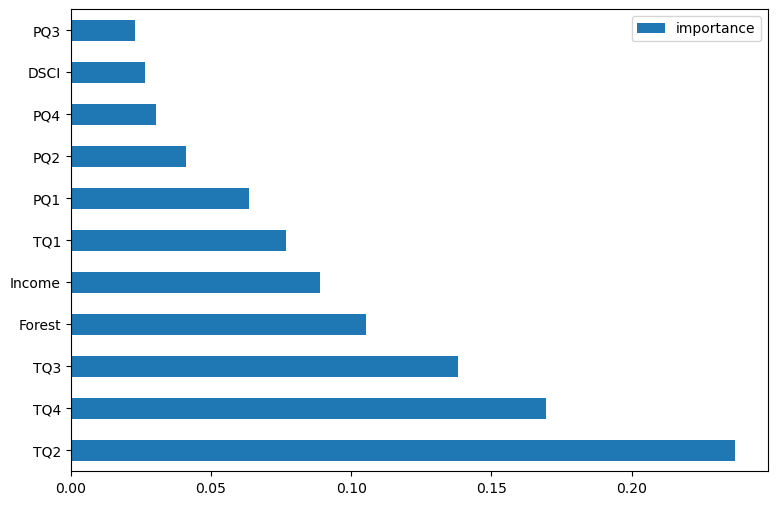

In [23]:
#Feature importance visualisation
feature_imp.plot(kind='barh')

# Logistic Regression

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [25]:
logreg_model = LogisticRegression()
logreg_model.fit(X_train, y_train)

# predict
y_pred = logreg_model.predict(X_test)

In [26]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.82      1.00      0.90         9
           2       0.80      1.00      0.89        12
           3       0.00      0.00      0.00         2

    accuracy                           0.81        26
   macro avg       0.40      0.50      0.45        26
weighted avg       0.65      0.81      0.72        26



/Users/rachelholman/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rachelholman/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rachelholman/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [27]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8076923076923077


In [28]:
feature_names = X_train.columns

coeffs = logreg_model.coef_[0]

coeffs_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coeffs})

coeffs_df['Abs_Coefficient'] = abs(coeffs_df['Coefficient'])
coeffs_df.sort_values(by='Abs_Coefficient', ascending=False, inplace=True)

<Axes: ylabel='Feature'>

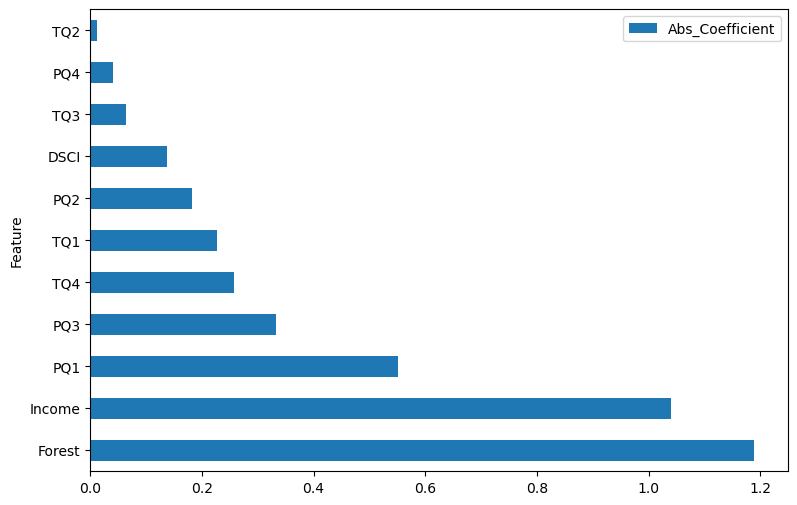

In [29]:
#Feature importance visualisation
coeffs_df.plot(kind='barh', x='Feature', y='Abs_Coefficient')

# Descision Tree

In [30]:
# supervised learning method
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor

In [31]:
dt_model = DecisionTreeClassifier(random_state=0)
dt_model.fit(X_train, y_train)

y_pred = dt_model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.89      0.89      0.89         9
           2       0.73      0.92      0.81        12
           3       1.00      0.50      0.67         2

    accuracy                           0.77        26
   macro avg       0.66      0.58      0.59        26
weighted avg       0.72      0.77      0.74        26



In [32]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.7692307692307693


In [33]:
cross_val_score(dt_model, X_train, y_train, cv=10)

/Users/rachelholman/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(


array([1.        , 0.83333333, 0.66666667, 1.        , 0.83333333,
       0.66666667, 0.66666667, 1.        , 0.8       , 1.        ])

# KNN

In [34]:
from sklearn.neighbors import KNeighborsClassifier
n_acc = [0]*11
for n in [1,2,3,4,5,6,7,8,9,10]:
    neigh = KNeighborsClassifier(n_neighbors=n)
    neigh.fit(X_train, y_train)
    preds = neigh.predict(X_test)
    correct = 0
    for i in range(len(preds)):
        if preds[i]==y_test.values[i]:
            correct += 1
    acc = correct/len(preds)
    n_acc[n] = acc
    print(f'{n} neighbors - validation accuracy: {round(acc, 5)} {correct}/{len(preds)}')

1 neighbors - validation accuracy: 0.88462 23/26
2 neighbors - validation accuracy: 0.80769 21/26
3 neighbors - validation accuracy: 0.84615 22/26
4 neighbors - validation accuracy: 0.84615 22/26
5 neighbors - validation accuracy: 0.88462 23/26
6 neighbors - validation accuracy: 0.88462 23/26
7 neighbors - validation accuracy: 0.88462 23/26
8 neighbors - validation accuracy: 0.76923 20/26
9 neighbors - validation accuracy: 0.80769 21/26
10 neighbors - validation accuracy: 0.76923 20/26


Text(0.5, 1.0, 'Validation Accuracy By Number of Neighbors')

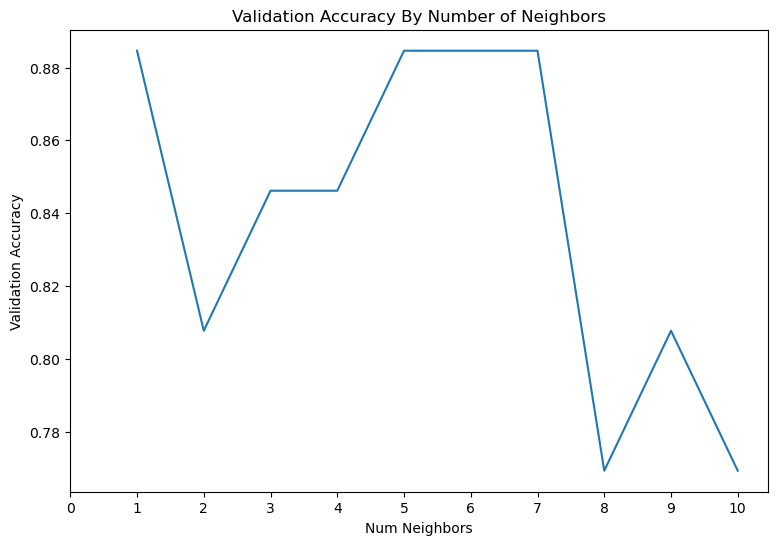

In [35]:
fig, ax = plt.subplots() 
ax.plot([i for i in range(1,len(n_acc))], n_acc[1:])
plt.xlabel('Num Neighbors')
plt.ylabel('Validation Accuracy')
ax.set_xticks(np.arange(len(n_acc)))
plt.title('Validation Accuracy By Number of Neighbors')

In [36]:
neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(X_train, y_train)

y_pred = neigh.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.2f}")
print("Test Classification Report:")
print(classification_report(y_test, y_pred))

Test Accuracy: 0.88
Test Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.67      0.80         3
           1       0.82      1.00      0.90         9
           2       0.92      1.00      0.96        12
           3       0.00      0.00      0.00         2

    accuracy                           0.88        26
   macro avg       0.69      0.67      0.67        26
weighted avg       0.82      0.88      0.85        26



/Users/rachelholman/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rachelholman/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rachelholman/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Naive Bayes

In [37]:
from sklearn.naive_bayes import MultinomialNB

naive_bayes_model = MultinomialNB()
naive_bayes_model.fit(X_train, y_train)
y_pred = naive_bayes_model.predict(X_test)

accuracy = accuracy_score(y_test.values, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print("Validation Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.46
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.00      0.00      0.00         9
           2       0.46      1.00      0.63        12
           3       0.00      0.00      0.00         2

    accuracy                           0.46        26
   macro avg       0.12      0.25      0.16        26
weighted avg       0.21      0.46      0.29        26



/Users/rachelholman/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rachelholman/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rachelholman/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Gradient Boost

In [38]:
from sklearn.datasets import make_hastie_10_2
from sklearn.ensemble import GradientBoostingClassifier

#fit gradient boosted stumps (trees w depth=1)
clf = GradientBoostingClassifier(n_estimators=100, 
                                 learning_rate=1.0, 
                                 max_depth=1, 
                                 random_state=0).fit(X_train, y_train)

In [39]:
clf.score(X_test, y_test)

0.8461538461538461

In [40]:
y_pred = clf.predict(X_test)

In [41]:
cr = classification_report(y_test, y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.60      1.00      0.75         3
           1       0.80      0.89      0.84         9
           2       1.00      0.92      0.96        12
           3       0.00      0.00      0.00         2

    accuracy                           0.85        26
   macro avg       0.60      0.70      0.64        26
weighted avg       0.81      0.85      0.82        26



/Users/rachelholman/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rachelholman/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rachelholman/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [42]:
feature_imp = pd.DataFrame(clf.feature_importances_,index= X_train.columns, columns=['importance']).sort_values('importance',ascending=False)
print(feature_imp)

        importance
TQ2       0.592092
Forest    0.160589
PQ1       0.141818
TQ4       0.044744
PQ4       0.024091
Income    0.016693
PQ3       0.014819
TQ3       0.004020
PQ2       0.000634
DSCI      0.000497
TQ1       0.000003


<Axes: >

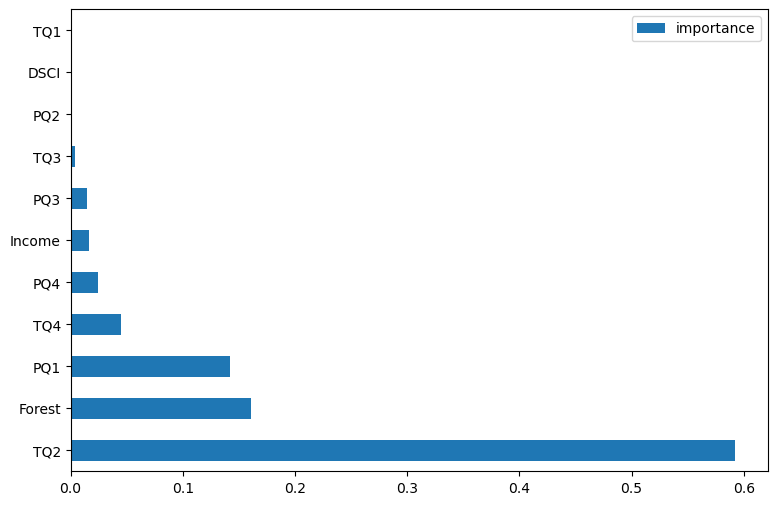

In [43]:
#Feature importance visualisation
feature_imp.plot(kind='barh')

# Neural Net
## Simple ANN

In [44]:
# loading everything that might be helpful
import sys
import sklearn
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from functools import partial
import PIL
import PIL.Image
import torch
from torch.utils.data import DataLoader, random_split
from torch import Generator
from torchvision.transforms import ToTensor
from torchvision.datasets import ImageFolder
from torch import manual_seed as torch_manual_seed
import random
import numpy as np

from torch.cuda import max_memory_allocated, set_device, manual_seed_all
from torch.backends import cudnn

In [45]:
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

In [46]:
# Test data = 6 counties of interst: Accomack, Fauquier, Greensville, Hanover, Rockingham, Wise
X_test = dataset_test
X_test = X_test[['Income','DSCI','PQ1','PQ2','PQ3','PQ4','TQ1','TQ2','TQ3','TQ4','Forest']]

# The test data will not have a cluster assigned- need to predict it
#y_test = df.loc[[51001, 51061, 51081, 51085, 51165, 51195]]
#y_test = y_test['cluster']

# Train data = all but 6 counties of interest
X_train = dataset_train
X_train_full = X_train[['Income','DSCI','PQ1','PQ2','PQ3','PQ4','TQ1','TQ2','TQ3','TQ4','Forest']]

y_train = dataset_train
y_train_full = y_train['cluster']

# Split into train and validation (80:20)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size= 0.2, random_state=49)

In [47]:
# Make training data into tensor objects
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)

# Make val data into tensor objects
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32)

# Make test data into tensor objects
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)

In [48]:
#train data
training_data = TensorDataset(X_train_tensor, y_train_tensor)
train_dataloader = DataLoader(training_data, batch_size=64)

#test data
test_data = TensorDataset(X_test_tensor)
test_dataloader = DataLoader(test_data, batch_size=64)

#validate data
val_data = TensorDataset(X_val_tensor, y_val_tensor)
val_dataloader = DataLoader(val_data, batch_size=64)

In [49]:
for X, y in val_dataloader:
    y = y.long()
    print(y)

tensor([1, 2, 1, 2, 2, 3, 1, 0, 1, 1, 2, 1, 0, 2, 0, 2, 0])


In [50]:
# Simple ANN

In [51]:
import torch.nn as nn

#define model
class net(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_model = nn.Sequential(
            nn.Linear(11,100), #11 input columns
            nn.Tanh(),
            nn.Linear(100,4)#4 output classes

    )

    def forward(self, x):
        logits = self.linear_model(x)
        return logits

model = net()
model

net(
  (linear_model): Sequential(
    (0): Linear(in_features=11, out_features=100, bias=True)
    (1): Tanh()
    (2): Linear(in_features=100, out_features=4, bias=True)
  )
)

In [52]:
learning_rate = 0.005
batch_size = 64
epochs = 25
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [53]:
#train loop
def train_loop(dataloader, model, loss_fn, optimizer):
    model.train() #set model in train mode
    size = len(dataloader.dataset)

    for batch, (X,y) in enumerate(dataloader):
        #prediction and loss
        #y = y.unsqueeze(1)
        y = y.long()
        pred = model(X)
        loss = loss_fn(pred, y)

        #backward pass
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    if batch % 1 == 0:
        loss, current = loss.item(), batch * batch_size + len(X)
        print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [54]:
def test_loop(train_dataloader, val_dataloader, model, loss_fn):
    model.eval()  # set model in evaluation mode

    size_train = len(train_dataloader.dataset)
    size_val = len(val_dataloader.dataset)

    num_batches_train = len(train_dataloader)
    num_batches_val = len(val_dataloader)

    train_loss, correct_train = 0, 0
    val_loss, correct_val = 0, 0

    # Evaluate model on train data
    with torch.no_grad():
        for X, y in train_dataloader:
            #y = y.unsqueeze(1)
            y = y.long()
            pred = model(X)
            train_loss += loss_fn(pred, y).item()
            correct_train += (pred.argmax(1) == y).type(torch.float).sum().item()

    train_loss /= num_batches_train
    correct_train /= size_train
    print(f"Train Error: \n Accuracy: {(100*correct_train):>0.1f}%, Avg loss: {train_loss:>8f}")

    # Evaluate model on validation data
    with torch.no_grad():
        for X, y in val_dataloader:
            #y = y.unsqueeze(1)
            y = y.long()
            pred = model(X)
            val_loss += loss_fn(pred, y).item()
            correct_val += (pred.argmax(1) == y).type(torch.float).sum().item()

    val_loss /= num_batches_val
    correct_val /= size_val
    print(f"Validation Error: \n Accuracy: {(100*correct_val):>0.1f}%, Avg loss: {val_loss:>8f}")


In [55]:
#run the code for
epochs = 200
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(train_dataloader, val_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 1.339606  [   67/   67]
Train Error: 
 Accuracy: 7.5%, Avg loss: 1.336449
Validation Error: 
 Accuracy: 11.8%, Avg loss: 1.337663
Epoch 2
-------------------------------
loss: 1.325494  [   67/   67]
Train Error: 
 Accuracy: 14.9%, Avg loss: 1.326379
Validation Error: 
 Accuracy: 35.3%, Avg loss: 1.331318
Epoch 3
-------------------------------
loss: 1.311895  [   67/   67]
Train Error: 
 Accuracy: 17.9%, Avg loss: 1.316728
Validation Error: 
 Accuracy: 29.4%, Avg loss: 1.325313
Epoch 4
-------------------------------
loss: 1.298786  [   67/   67]
Train Error: 
 Accuracy: 23.9%, Avg loss: 1.307475
Validation Error: 
 Accuracy: 35.3%, Avg loss: 1.319628
Epoch 5
-------------------------------
loss: 1.286144  [   67/   67]
Train Error: 
 Accuracy: 25.4%, Avg loss: 1.298601
Validation Error: 
 Accuracy: 35.3%, Avg loss: 1.314247
Epoch 6
-------------------------------
loss: 1.273948  [   67/   67]
Train Error: 
 Accuracy: 25.4%, Avg loss: 1.29

In [56]:
# Note: ann above stagnates after ~200 epochs

## Feed Forward ANN (MLPClassifier from sklearn)

In [57]:
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

clf = MLPClassifier(random_state=1, max_iter=300).fit(X_train, y_train)

/Users/rachelholman/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


In [58]:
clf

MLPClassifier(max_iter=300, random_state=1)

In [59]:
clf.predict_proba(X_val)

array([[0.39288166, 0.53150067, 0.03988034, 0.03573734],
       [0.05629019, 0.00999102, 0.92398809, 0.0097307 ],
       [0.19293684, 0.64208792, 0.07604437, 0.08893086],
       [0.26651506, 0.06300134, 0.64006383, 0.03041976],
       [0.09940403, 0.00423281, 0.89184353, 0.00451963],
       [0.02817765, 0.90166106, 0.00279033, 0.06737095],
       [0.0877717 , 0.86171924, 0.01006397, 0.0404451 ],
       [0.25229098, 0.10038593, 0.61260293, 0.03472016],
       [0.13177502, 0.70882812, 0.06877593, 0.09062093],
       [0.20825054, 0.61924001, 0.10907242, 0.06343703],
       [0.15789108, 0.0566973 , 0.75467899, 0.03073262],
       [0.07750788, 0.44671596, 0.26587008, 0.20990608],
       [0.56013336, 0.40186187, 0.0225684 , 0.01543637],
       [0.1893382 , 0.01333427, 0.78558496, 0.01174256],
       [0.59379278, 0.20176984, 0.17997991, 0.02445747],
       [0.09494997, 0.01327994, 0.87746128, 0.01430882],
       [0.59620771, 0.189693  , 0.19434419, 0.0197551 ]])

In [60]:
y_pred = clf.predict(X_val)
y_pred

array([1, 2, 1, 2, 2, 1, 1, 2, 1, 1, 2, 1, 0, 2, 0, 2, 0])

In [61]:
y_val

County
51145    1
51053    2
51197    1
51015    2
51077    2
51107    3
51111    1
51003    0
51113    1
51091    1
51177    2
51043    1
51027    0
51099    2
51125    0
51183    2
51005    0
Name: cluster, dtype: int64

In [62]:
clf.score(X_val, y_val)

0.8823529411764706

In [63]:
cr = classification_report(y_val, y_pred)
print(cr)

              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.86      1.00      0.92         6
           2       0.86      1.00      0.92         6
           3       0.00      0.00      0.00         1

    accuracy                           0.88        17
   macro avg       0.68      0.69      0.68        17
weighted avg       0.84      0.88      0.85        17



/Users/rachelholman/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rachelholman/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rachelholman/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
